In [107]:
from utils.runn import *
import zsyGame as zsy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import tf_utils as tu
import math
import time
import pickle
from datetime import timedelta

In [4]:
X_A, X_B, Y_A, Y_B = zsy.dataFileToLabeledData_1(r'data\1M RandvRand\T100k_0.h5')
X_A = X_A[:,:,0].T
X_B = X_B[:,:,0].T
Y_A = Y_A[:,:,0].T
Y_B = Y_B[:,:,0].T

In [58]:
X_Train = X_A[:,:int(X_A.shape[1]*.96)]
X_Dev = X_A[:,int(X_A.shape[1]*.96):int(X_A.shape[1]*.98)]
X_Test = X_A[:,int(X_A.shape[1]*.98):]
Y_Train = convertYToLogistic(Y_A[:,:int(X_A.shape[1]*.96)], 0.9)
Y_Dev = convertYToLogistic(Y_A[:,int(X_A.shape[1]*.96):int(X_A.shape[1]*.98)], 0.9)
Y_Test = convertYToLogistic(Y_A[:,int(X_A.shape[1]*.98):], 0.9)

In [31]:
# Original Y is Y[0] = 1 if win, -1 if lose
# Y[1] is how many steps away from the end of the game
def convertY(Y, discount):
    return (Y[0]*discount**Y[1]).reshape(1,-1)

def convertYToLogistic(Y, discount):
    return (convertY(Y, discount) + 1)/2

In [95]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    ### END CODE HERE ###
    
    return X, Y


def initialize_parameters(n_x, n_1, n_2, n_3=1):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [n_1, n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [n_1,1], initializer = tf.zeros_initializer)
    W2 = tf.get_variable("W2", [n_2, n_1], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [n_2,1], initializer = tf.zeros_initializer)
    W3 = tf.get_variable("W3", [n_3, n_2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_3,1], initializer = tf.zeros_initializer)
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X),b1)                                       # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob)                                             # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1),b2)                                                 # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2),b3)                                                 # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3


def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    predictions = tf.transpose(tf.sigmoid(Z3))
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.losses.log_loss(labels, predictions)
    ### END CODE HERE ###
    
    return cost

In [108]:
def model(X_train, Y_train, X_test, Y_test, keep_prob, n_1, n_2, n_3=1, learning_rate = 0.001,
          num_epochs = 1500, minibatch_size = 1024, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    dev_costs = []
    print("nx:%d ny:%d, m:%d"%(n_x, n_y, m))
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters(n_x, n_1, n_2, n_3)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters, keep_prob)
    Z3_ = forward_propagation(X, parameters, 1.0)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    cost_ = compute_cost(Z3_, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            if(epoch==0):
                tic0 = time.time()
            if(epoch==10):
                tic10 = time.time()

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            if(epoch==0):
                print("num minibatches:%d"%(num_minibatches))
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            tic = time.time()
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches
            toc = time.time()
            if epoch == 0:
                print ("\tEpoch time:%d seconds"%(toc-tic))
            if epoch == 10:
                print ("\tAve epoch time: %f"%((tic10-tic0)/10))
                print ("\t100 epochs will take %s"%(timedelta(seconds=10*(tic10-tic0))))
            # Print the cost every epoch
            if print_cost == True and (epoch % 5 == 0 or epoch < 10):
                dev_cost = sess.run(cost_, feed_dict={X: X_test, Y:Y_test})
            if print_cost == True and (epoch % 10 == 0 or epoch < 10):
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("\tDev error (no dropout): %f"%(dev_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                dev_costs.append(dev_cost)
                
        # plot the cost
        xrange = 5*np.arange(num_epochs/5)
        plt.plot(xrange, np.squeeze(costs), xrange, np.squeeze(dev_costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        train_cost = sess.run(cost_, feed_dict={X: X_train, Y:Y_train})
        dev_cost = sess.run(cost_, feed_dict={X: X_test, Y:Y_test})

        print ("Train cost (No dropout):", train_cost)
        print ("Test cost (No dropout):", dev_cost)
        
        return parameters

In [66]:
def computeCosts(X, Y, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    x = tf.placeholder("float", [300, None])
    Z3 = tu.forward_propagation_for_predict(x, params)
    A3 = tf.transpose(tf.sigmoid(Z3))
    labels = tf.transpose(Y)
    cost = tf.losses.log_loss(labels, A3)
    sess = tf.Session()
    cost = sess.run(cost, feed_dict = {x: X})  
    return cost

nx:300 ny:1, m:1861134
num minibatches:1817
	Epoch time:38 seconds
Cost after epoch 0: 0.650832
	Dev error (no dropout): 0.638112
Cost after epoch 1: 0.640046
	Dev error (no dropout): 0.635958
Cost after epoch 2: 0.638129
	Dev error (no dropout): 0.635203
Cost after epoch 3: 0.637196
	Dev error (no dropout): 0.634092
Cost after epoch 4: 0.636387
	Dev error (no dropout): 0.635001
Cost after epoch 5: 0.635772
	Dev error (no dropout): 0.632879
Cost after epoch 6: 0.635417
	Dev error (no dropout): 0.633527
Cost after epoch 7: 0.635001
	Dev error (no dropout): 0.633207
Cost after epoch 8: 0.634877
	Dev error (no dropout): 0.633370
Cost after epoch 9: 0.635202
	Dev error (no dropout): 0.633896
	Ave epoch time: 41.977839
	100 epochs will take 1:09:57.783859
Cost after epoch 10: 0.634866
	Dev error (no dropout): 0.633742
Cost after epoch 20: 0.633153
	Dev error (no dropout): 0.634044
Cost after epoch 30: 0.632482
	Dev error (no dropout): 0.633703
Cost after epoch 40: 0.632507
	Dev error (no dr

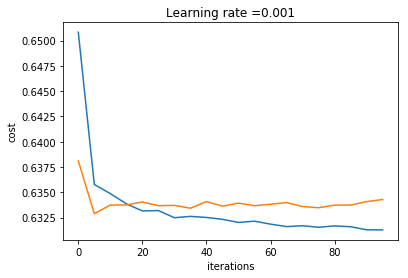

Parameters have been trained!
Train cost (No dropout): 0.62401
Test cost (No dropout): 0.634024


In [109]:
parameters = model(X_Train, Y_Train, X_Dev, Y_Dev, 0.5, 200, 40, num_epochs = 100)

In [112]:
computeCosts(X_Train, Y_Train, parameters)

0.62400979

In [111]:
computeCosts(X_Dev, Y_Dev, parameters)

0.63402367

In [89]:
print(computeCosts(X_Train, Y_Train, params), computeCosts(X_Dev, Y_Dev, params))

0.626561 0.635208


In [113]:
tu.predict(X_Dev[:,:3], parameters)

array([[ 0.47493479,  0.48097113,  0.49750122]], dtype=float32)

In [110]:
reload(tu)

<module 'tf_utils' from 'C:\\Users\\darky\\Downloads\\!CS230\\ZSY\\tf_utils.py'>

In [114]:
f = open("Parameters_100epochs_dropout.pkl", 'wb+')
pickle.dump(parameters, f)
f.close()

In [87]:
f = open("Parameters_100epochs_dropout.pkl", 'rb')
params = pickle.load(f)
f.close()